Imports and Install Libraries

In [12]:
!pip install -q transformers accelerate ftfy safetensors einops timm

# Imports
import os, csv, re, math, time
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel

Mount Drive and set file paths

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR = "/content/drive/MyDrive/499A Datasets"
METADATA_PATH = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "metadata_augmented.csv")
HERB_TEXT_PATH = os.path.join(BASE_DIR, "Preprocessed", "herb2_final_clean.csv")

EMB_SAVE_DIR = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "clip_embeddings")
Path(EMB_SAVE_DIR).mkdir(parents=True, exist_ok=True)

# output paths
TRAIN_IMG_EMB = os.path.join(EMB_SAVE_DIR, "img_train_emb.npy")
TEST_IMG_EMB  = os.path.join(EMB_SAVE_DIR, "img_test_emb.npy")
HERB_TEXT_EMB = os.path.join(EMB_SAVE_DIR, "herb_text_emb.npy")
RETRIEVAL_CSV  = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "clip_test_retrieval_results.csv")

print("Metadata:", METADATA_PATH)
print("Herb text:", HERB_TEXT_PATH)
print("Embeddings dir:", EMB_SAVE_DIR)
print("Retrieval CSV:", RETRIEVAL_CSV)

Mounted at /content/drive
Metadata: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/metadata_augmented.csv
Herb text: /content/drive/MyDrive/499A Datasets/Preprocessed/herb2_final_clean.csv
Embeddings dir: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/clip_embeddings
Retrieval CSV: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/clip_test_retrieval_results.csv


Load metadata and herb

In [14]:
meta = pd.read_csv(METADATA_PATH)
herb = pd.read_csv(HERB_TEXT_PATH, low_memory=False)

# Normalize column names
meta.columns = [c.strip() for c in meta.columns]
herb.columns = [c.strip() for c in herb.columns]

print("metadata rows:", len(meta), "columns:", meta.columns.tolist())
print("herb rows:", len(herb), "columns:", herb.columns.tolist())
display(meta.head(3))
display(herb[['Herb_en_name','Disease_name','text_for_vlm']].head(3))
meta = pd.read_csv(METADATA_PATH)
herb = pd.read_csv(HERB_TEXT_PATH, low_memory=False)

metadata rows: 48956 columns: ['subset', 'class_name', 'image_path', 'text_prompt']
herb rows: 44595 columns: ['Herb_id', 'Herb_en_name', 'Herb_latin_name', 'Properties', 'Meridians', 'UsePart', 'Function', 'Indication', 'Toxicity', 'Ingredient_id', 'Ingredient_name', 'Ingredient_alias_name', 'Molecular_formula', 'Drug_likeness', 'OB_score', 'CAS_id', 'PubChem_id', 'Disease_id', 'Disease_name', 'Disease_alias_name', 'UMLS_disease_type', 'MeSH_disease_class', 'text_for_vlm']


,subset,class_name,image_path,text_prompt
0,train,Acne and Rosacea Photos,/content/drive/MyDrive/499A Datasets/Dermnet/p...,Photo of dermatologic condition: acne & rosacea.
1,train,Acne and Rosacea Photos,/content/drive/MyDrive/499A Datasets/Dermnet/p...,Clinical photo depicting acne & rosacea.
2,train,Acne and Rosacea Photos,/content/drive/MyDrive/499A Datasets/Dermnet/p...,Image of human skin showing acne & rosacea.


,Herb_en_name,Disease_name,text_for_vlm
0,Abyssinia Coralbean,"Abdomen, Acute",Abyssinia Coralbean | Erythrina Abyssinica | O...
1,Abyssinia Harrisonia,Abdominal Cramps,Abyssinia Harrisonia | Harrisonia Abyssinica |...
2,Algerian Cottonthistle,Abdomen Distended,Algerian Cottonthistle | Onopordum Algeriense ...


Train and Test lists

In [15]:
# subset values
meta['subset'] = meta['subset'].astype(str).str.lower()

train_meta = meta[meta['subset']=='train'].reset_index(drop=True)
test_meta  = meta[meta['subset']=='test'].reset_index(drop=True)

print("Train images:", len(train_meta))
print("Test images: ", len(test_meta))

# lists
train_image_paths = train_meta['image_path'].tolist()
test_image_paths  = test_meta['image_path'].tolist()

# herb texts (use text_for_vlm)
if 'text_for_vlm' not in herb.columns:
    # fallback build from columns if missing
    def build_text(r):
        parts=[]
        for c in ['Herb_en_name','Herb_latin_name','Properties','Function','Indication','Toxicity','MeSH_disease_class']:
            if c in herb.columns and pd.notna(r.get(c,'')):
                parts.append(str(r.get(c)))
        return " | ".join(parts)
    herb['text_for_vlm'] = herb.apply(build_text, axis=1)

herb_texts = herb['text_for_vlm'].fillna('').astype(str).tolist()
print("Herb text count:", len(herb_texts))

Train images: 38945
Test images:  10011
Herb text count: 44595


Load CLIP model and processor

In [16]:
MODEL_NAME = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_model.eval()

Using device: cpu


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

Embeddings helper for image and text

In [17]:
def compute_image_embeddings(image_paths, batch_size=32, save_path=None):
    all_embs = []
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Images"):
        batch = image_paths[i:i+batch_size]
        images = []
        for p in batch:
            try:
                img = Image.open(p).convert('RGB')
            except Exception as e:
                print("Warning: can't open", p, "-> using blank image")
                img = Image.new('RGB', (224,224), (128,128,128))
            images.append(img)
        inputs = processor(images=images, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs)   # [B, dim]
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
            all_embs.append(emb.cpu().numpy())
    if len(all_embs)==0:
        arr = np.zeros((0, clip_model.visual_projection.out_features))
    else:
        arr = np.vstack(all_embs)
    if save_path:
        np.save(save_path, arr)
    return arr

def compute_text_embeddings(texts, batch_size=64, save_path=None):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Texts"):
        batch = texts[i:i+batch_size]
        inputs = processor(text=batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            emb = clip_model.get_text_features(**inputs)
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
            all_embs.append(emb.cpu().numpy())
    if len(all_embs)==0:
        arr = np.zeros((0, clip_model.text_projection.out_features))
    else:
        arr = np.vstack(all_embs)
    if save_path:
        np.save(save_path, arr)
    return arr

Compute embeddings for all train or test images and all herb texts

In [18]:
# Train image
if os.path.exists(TRAIN_IMG_EMB):
    img_train_embs = np.load(TRAIN_IMG_EMB)
    print("Loaded train image embeddings:", img_train_embs.shape)
else:
    img_train_embs = compute_image_embeddings(train_image_paths, batch_size=32, save_path=TRAIN_IMG_EMB)
    print("Saved train image embeddings:", img_train_embs.shape)

# Test image
if os.path.exists(TEST_IMG_EMB):
    img_test_embs = np.load(TEST_IMG_EMB)
    print("Loaded test image embeddings:", img_test_embs.shape)
else:
    img_test_embs = compute_image_embeddings(test_image_paths, batch_size=32, save_path=TEST_IMG_EMB)
    print("Saved test image embeddings:", img_test_embs.shape)

# Herb text
if os.path.exists(HERB_TEXT_EMB):
    herb_text_embs = np.load(HERB_TEXT_EMB)
    print("Loaded herb text embeddings:", herb_text_embs.shape)
else:
    herb_text_embs = compute_text_embeddings(herb_texts, batch_size=64, save_path=HERB_TEXT_EMB)
    print("Saved herb text embeddings:", herb_text_embs.shape)

Loaded train image embeddings: (38945, 512)
Loaded test image embeddings: (10011, 512)
Loaded herb text embeddings: (44595, 512)


Prediction function (test image to predicted disease and top-N herbs)

In [20]:
def predict_for_image_path(img_path, topk_herb=5):
    # compute embedding for single image
    img = Image.open(img_path).convert('RGB')
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
        emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
    emb = emb.cpu().numpy()  # shape (1, D)
    # nearest train image (disease prediction)
    sims_train = emb @ img_train_embs.T   # (1, N_train)
    top_train_idx = int(np.argmax(sims_train, axis=1)[0])
    predicted_disease = train_meta.iloc[top_train_idx]['class_name']
    conf_train = float(sims_train[0, top_train_idx])
    # nearest herb texts
    sims_herb = emb @ herb_text_embs.T   # (1, N_herb)
    topk_idxs = list(np.argsort(-sims_herb[0])[:topk_herb])
    herbs = [herb_texts[i] for i in topk_idxs]
    herb_scores = [float(sims_herb[0, i]) for i in topk_idxs]
    return {
        "predicted_disease": predicted_disease,
        "disease_confidence": conf_train,
        "top_herb_texts": herbs,
        "top_herb_scores": herb_scores,
        "nearest_train_index": top_train_idx
    }

Run prediction for all test images and save human-readable text outputs

In [21]:
# Loop over test set and produce a text summary per test image (can take time)
rows = []
for i, row in tqdm(test_meta.iterrows(), total=len(test_meta), desc="Predict test images"):
    img_path = row['image_path']
    try:
        res = predict_for_image_path(img_path, topk_herb=5)
    except Exception as e:
        print("Error on", img_path, e)
        continue

    # parse top herb texts into labeled fields (robust)
    parsed_herbs = []
    for htxt in res['top_herb_texts']:
        parts = [p.strip() for p in str(htxt).split('|') if p.strip() and p.strip().lower()!='nan']
        parsed_herbs.append(parts)

    # create readable summary string
    summary_lines = []
    summary_lines.append(f"Input image: {img_path}")
    summary_lines.append(f"Predicted skin disease (nearest train image): {res['predicted_disease']}  (score={res['disease_confidence']:.4f})")
    summary_lines.append("Top herb/compound matches (top-5):")
    for rank, (parts, score) in enumerate(zip(parsed_herbs, res['top_herb_scores']), start=1):
        summary_lines.append(f" Rank {rank} (score={score:.4f}):")
        # show up to first 6 parts to avoid too long lines
        labels = ["Herb English","Herb Latin","Properties","Meridians","UsePart","Function","Compound","Formula","RelatedDisease","DiseaseType","MeSH"]
        for j, p in enumerate(parts[:6]):
            label = labels[j] if j < len(labels) else f"Part{j+1}"
            summary_lines.append(f"    {label}: {p}")
    summary = "\n".join(summary_lines)

    rows.append({
        "image_path": img_path,
        "predicted_disease": res['predicted_disease'],
        "disease_confidence": res['disease_confidence'],
        "top_herb_texts_joined": " || ".join([(" | ".join(p)) for p in parsed_herbs]),
        "raw_topk_indices": "|".join(map(str, res['top_herb_scores'])),
        "text_summary": summary
    })

# Save CSV with text summaries (human readable)
out_df = pd.DataFrame(rows)
out_df.to_csv(RETRIEVAL_CSV, index=False)
print("Saved test retrieval summaries to:", RETRIEVAL_CSV)


Predict test images:   0%|          | 0/10011 [00:00<?, ?it/s]

Saved test retrieval summaries to: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/clip_test_retrieval_results.csv


Output using test image

Displaying test image: /content/drive/MyDrive/499A Datasets/Dermnet/preprocessed/test/Acne and Rosacea Photos/acne-histology-5.jpg

Saved summary (from CSV):

Input image: /content/drive/MyDrive/499A Datasets/Dermnet/preprocessed/test/Acne and Rosacea Photos/acne-histology-5.jpg
Predicted skin disease (nearest train image): Eczema Photos  (score=0.9262)
Top herb/compound matches (top-5):
 Rank 1 (score=0.3296):
    Herb English: Oleum Pini
    Herb Latin: Oleum Pini
    Properties: Dispel windkill worms
    Meridians: Scabies; Psoriasis
    UsePart: Bitter; Warm
    Function: 2-ethylhexenal
 Rank 2 (score=0.3296):
    Herb English: Alpha-acetyldigitoxin
    Herb Latin: C43H66O14
    Properties: Mucinous Carcinoma of Breast
    Meridians: Neoplastic Process
    UsePart: Skin and Connective Tissue Diseases; Neoplasms
 Rank 3 (score=0.3289):
    Herb English: 3-octyl-2-ethylene oxide octylate
    Herb Latin: Vaginal Intraepithelial Neoplasia
    Properties: Neoplastic Process
    Meridian

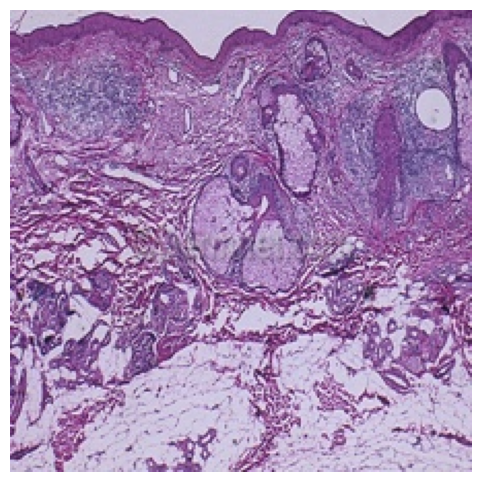

In [25]:
# Choose test index to display (0..len(test_meta)-1)
idx = 200
test_row = test_meta.iloc[idx]
img_path = test_row['image_path']
print("Displaying test image:", img_path)
img = Image.open(img_path).convert('RGB')
plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis('off')

# Print summary from saved CSV
if os.path.exists(RETRIEVAL_CSV):
    df_out = pd.read_csv(RETRIEVAL_CSV)
    print("\nSaved summary (from CSV):\n")
    print(df_out.iloc[idx]['text_summary'])
else:
    # compute live
    res = predict_for_image_path(img_path, topk_herb=5)
    print("Predicted disease:", res['predicted_disease'])
    for r, (txt, s) in enumerate(zip(res['top_herb_texts'], res['top_herb_scores']), start=1):
        print(f"\nRank {r} (score {s:.4f}):\n", txt[:400])